In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time
import re

from scipy.sparse import csr_matrix

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, brier_score_loss, log_loss, r2_score

from category_encoders import TargetEncoder, CatBoostEncoder, GLMMEncoder

from lightgbm import LGBMRegressor
from statsforecast import StatsForecast

from utils import elo_predict, MatchElo, load_atp_data, get_player_sets_won

sys.path.append('../')
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 999

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [186]:
df = load_atp_data()

shape before dropping match dupes: (583792, 75)
shape after dropping match dupes: (583731, 75)


In [187]:
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,ranking_date,rank,player,points,retired,walkover,winner_initial,loser_initial,total_sets,winner_points,loser_points,month,w_2ndsvOpps,l_2ndsvOpps,w_1stReturnOpps,w_2ndReturnOpps,w_1stReturnPts,w_2ndReturnPts,l_1stReturnOpps,l_2ndReturnOpps,l_1stReturnPts,l_2ndReturnPts,w_bpOpps,w_bpWon,l_bpOpps,l_bpWon
0,2000-M-SA-PAN-01A-2000a,Central America Masters 1,Clay,32.0,S,2000-01-01,1.0,103204.0,1.0,NaN,Hugo Armando,R,183.0,USA,21.5,102283.0,NaN,WC,Yari Bernardo,R,NaN,ITA,26.1,6-3 6-1,3.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,269.0,148.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,Armando H.,Bernardo Y.,2,18,16,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-M-SA-PAN-01A-2000a,Central America Masters 1,Clay,32.0,S,2000-01-01,2.0,103363.0,NaN,NaN,Diego Ayala,R,175.0,USA,20.6,103437.0,NaN,Q,Francesco Piccari,R,NaN,ITA,20.3,7-5 4-6 6-4,3.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,749.0,17.0,1075.0,4.0,NaN,NaN,NaN,NaN,0,0,Ayala D.,Piccari F.,3,14,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-M-SA-PAN-01A-2000a,Central America Masters 1,Clay,32.0,S,2000-01-01,3.0,103405.0,NaN,NaN,Rodolfo Rake,R,NaN,PER,20.4,103262.0,NaN,NaN,Marc Canovas,R,NaN,ESP,21.2,7-6(3) 6-0,3.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,473.0,59.0,711.0,19.0,NaN,NaN,NaN,NaN,0,0,Rake R.,Canovas M.,2,12,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-M-SA-PAN-01A-2000a,Central America Masters 1,Clay,32.0,S,2000-01-01,4.0,102544.0,NaN,Q,Pablo Bianchi,R,NaN,URU,24.8,103525.0,8.0,NaN,Ivan Miranda,R,175.0,PER,19.8,7-5 6-2,3.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,847.0,11.0,810.0,13.0,NaN,NaN,NaN,NaN,0,0,Bianchi P.,Miranda I.,2,12,8,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-M-SA-PAN-01A-2000a,Central America Masters 1,Clay,32.0,S,2000-01-01,5.0,103399.0,3.0,NaN,Carlos Rexach Itoiz,U,NaN,ESP,20.4,101840.0,NaN,NaN,Jacobo Chavez,R,NaN,GUA,28.9,6-4 6-0,3.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1151.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,Itoiz C.,Chavez J.,2,13,13,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
# after some inspection, i somehow ended up with winner/loser
# points that are wrong after index 2938 in the original df
# so i'll re-do it
a, b = get_player_sets_won(df)

df['winner_sets'] = a
df['loser_sets'] = b
df['set_differential'] = df['winner_sets'].sub(df['loser_sets'])

In [189]:
# how often does the winner score more points? 

(df['winner_sets'] > df['loser_sets']).mean()

0.9543402697475378

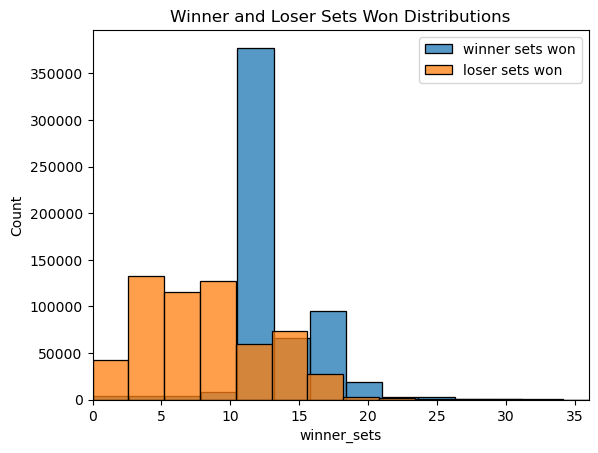

In [190]:
sns.histplot(df['winner_sets'], bins=35, label="winner sets won")
sns.histplot(df['loser_sets'], bins=35, label="loser sets won")

plt.xlim(0, 36)
plt.title("Winner and Loser Sets Won Distributions")
plt.legend()
plt.show()

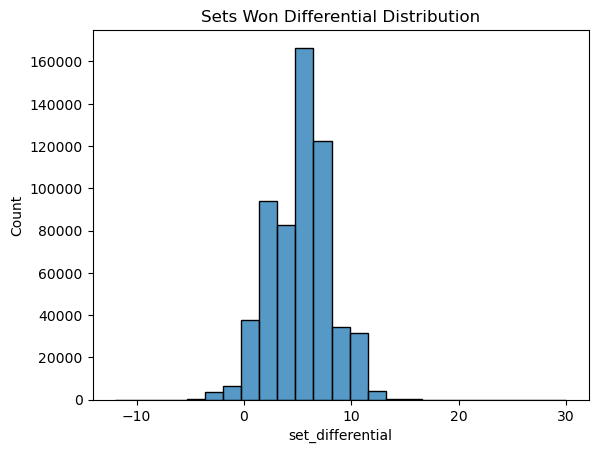

In [191]:
sns.histplot(df['set_differential'], bins=25)

plt.title("Sets Won Differential Distribution")
plt.show()

In [192]:
# creating a dictionary of player names
player_name_dict = (
    df
    .groupby('loser_id')['loser_name']
    .unique()
    .apply(lambda x: x[0])
    .to_dict()
)

In [193]:
generic_elo = MatchElo(df).process_elo()

df['generic_winner_prob'] = generic_elo.winner_probs
df['generic_winner_elo' ] = generic_elo.winner_elo
df['generic_loser_elo'] = generic_elo.loser_elo

# creating dataframes for each surface

hard_df = df[df['surface'] == 'Hard'].copy()
clay_df = df[df['surface'] == 'Clay'].copy()
grass_df = df[df['surface'] == 'Grass'].copy()
carpet_df = df[df['surface'] == 'Carpet'].copy()

hard_elo = MatchElo(hard_df, base_k=56).process_elo()
clay_elo = MatchElo(clay_df, base_k=60).process_elo()
grass_elo = MatchElo(grass_df, base_k=54).process_elo()
carpet_elo = MatchElo(carpet_df, base_k=49).process_elo()

# calculating surface elo and adding win probabilities to the df
hard_df['surface_winner_prob'] = hard_elo.winner_probs
clay_df['surface_winner_prob'] = clay_elo.winner_probs
grass_df['surface_winner_prob'] = grass_elo.winner_probs
carpet_df['surface_winner_prob'] = carpet_elo.winner_probs

# adding elo ratings to the dataframe
hard_df['surface_winner_elo'] = hard_elo.winner_elo
clay_df['surface_winner_elo'] = clay_elo.winner_elo
grass_df['surface_winner_elo'] = grass_elo.winner_elo
carpet_df['surface_winner_elo'] = carpet_elo.winner_elo

# adding elo ratings to the dataframe
hard_df['surface_loser_elo'] = hard_elo.loser_elo
clay_df['surface_loser_elo'] = clay_elo.loser_elo
grass_df['surface_loser_elo'] = grass_elo.loser_elo
carpet_df['surface_loser_elo'] = carpet_elo.loser_elo

elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully


In [194]:
# recreating the original dataframe from the surface
# splits
df = (
    pd.concat(
        [hard_df, clay_df, grass_df, carpet_df])
    .sort_values(by=['tourney_date', 'tourney_id', 'round'],
                 ascending=[True, True, True])
    .reset_index(drop=True)
)

df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,ranking_date,rank,player,points,retired,walkover,winner_initial,loser_initial,total_sets,winner_points,loser_points,month,w_2ndsvOpps,l_2ndsvOpps,w_1stReturnOpps,w_2ndReturnOpps,w_1stReturnPts,w_2ndReturnPts,l_1stReturnOpps,l_2ndReturnOpps,l_1stReturnPts,l_2ndReturnPts,w_bpOpps,w_bpWon,l_bpOpps,l_bpWon,winner_sets,loser_sets,set_differential,generic_winner_prob,generic_winner_elo,generic_loser_elo,surface_winner_prob,surface_winner_elo,surface_loser_elo
0,2000-M-SA-PAN-01A-2000a,Central America Masters 1,Clay,32.0,S,2000-01-01,1.0,103204.0,1.0,NaN,Hugo Armando,R,183.0,USA,21.5,102283.0,NaN,WC,Yari Bernardo,R,NaN,ITA,26.1,6-3 6-1,3.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,269.0,148.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,Armando H.,Bernardo Y.,2,18,16,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,4,8,0.5,1500.0,1500.0,0.5,1500.0,1500.0
1,2000-M-SA-PAN-01A-2000a,Central America Masters 1,Clay,32.0,S,2000-01-01,2.0,103363.0,NaN,NaN,Diego Ayala,R,175.0,USA,20.6,103437.0,NaN,Q,Francesco Piccari,R,NaN,ITA,20.3,7-5 4-6 6-4,3.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,749.0,17.0,1075.0,4.0,NaN,NaN,NaN,NaN,0,0,Ayala D.,Piccari F.,3,14,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,15,2,0.5,1500.0,1500.0,0.5,1500.0,1500.0
2,2000-M-SA-PAN-01A-2000a,Central America Masters 1,Clay,32.0,S,2000-01-01,3.0,103405.0,NaN,NaN,Rodolfo Rake,R,NaN,PER,20.4,103262.0,NaN,NaN,Marc Canovas,R,NaN,ESP,21.2,7-6(3) 6-0,3.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,473.0,59.0,711.0,19.0,NaN,NaN,NaN,NaN,0,0,Rake R.,Canovas M.,2,12,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,6,7,0.5,1500.0,1500.0,0.5,1500.0,1500.0
3,2000-M-SA-PAN-01A-2000a,Central America Masters 1,Clay,32.0,S,2000-01-01,4.0,102544.0,NaN,Q,Pablo Bianchi,R,NaN,URU,24.8,103525.0,8.0,NaN,Ivan Miranda,R,175.0,PER,19.8,7-5 6-2,3.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,847.0,11.0,810.0,13.0,NaN,NaN,NaN,NaN,0,0,Bianchi P.,Miranda I.,2,12,8,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,7,6,0.5,1500.0,1500.0,0.5,1500.0,1500.0
4,2000-M-SA-PAN-01A-2000a,Central America Masters 1,Clay,32.0,S,2000-01-01,5.0,103399.0,3.0,NaN,Carlos Rexach Itoiz,U,NaN,ESP,20.4,101840.0,NaN,NaN,Jacobo Chavez,R,NaN,GUA,28.9,6-4 6-0,3.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1151.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,Itoiz C.,Chavez J.,2,13,13,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,4,8,0.5,1500.0,1500.0,0.5,1500.0,1500.0


In [132]:
# converting tourney date column to datetime
df['tourney_date'] = pd.to_datetime(df['tourney_date'])

# getting total points won by winner and loser
df['winner_points'] = (
    df['w_1stWon'] + df['w_2ndWon'] + (df['l_svpt'] - (df['l_1stWon'] + df['l_2ndWon']))
)

df['loser_points'] = (
    df['l_1stWon'] + df['l_2ndWon'] + (df['w_svpt'] - (df['w_1stWon'] + df['w_2ndWon']))
)

# getting winner serve and return win%
df['w_ServeWin'] = (df['w_1stWon'] + df['w_2ndWon']) / df['w_svpt']
df['l_ReturnWin'] = 1 - df['w_ServeWin']
df['w_BpSavePerc'] = df['w_bpSaved'].div(df['w_bpFaced'])
df['w_BpWinPerc'] = df['l_bpSaved'].div(df['l_bpFaced'])

# getting loser serve and return win%
df['l_ServeWin'] = (df['l_1stWon'] + df['l_2ndWon']) / df['l_svpt']
df['w_ReturnWin'] = 1 - df['l_ServeWin']
df['l_BpSavePerc'] = df['l_bpSaved'].div(df['l_bpFaced'])
df['l_BpWinPerc'] = df['w_bpSaved'].div(df['w_bpFaced'])

# getting the elo win probabilities for the winners and losers
df['winner_generic_elo_winprob'] = elo_predict(df['generic_winner_elo'], df['generic_loser_elo'])
df['loser_generic_elo_winprob'] = 1 - df['winner_generic_elo_winprob']

df['winner_surface_elo_winprob'] = elo_predict(df['surface_winner_elo'], df['surface_loser_elo'])
df['loser_surface_elo_winprob'] = 1 - df['winner_surface_elo_winprob']

In [133]:
# now dropping the rows without enough statistics
df = df[df['w_svpt'] > 10].copy()
df.dropna(subset=['w_ServeWin'], inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,ranking_date,rank,player,points,retired,walkover,winner_initial,loser_initial,total_sets,winner_points,loser_points,month,w_2ndsvOpps,l_2ndsvOpps,w_1stReturnOpps,w_2ndReturnOpps,w_1stReturnPts,w_2ndReturnPts,l_1stReturnOpps,l_2ndReturnOpps,l_1stReturnPts,l_2ndReturnPts,w_bpOpps,w_bpWon,l_bpOpps,l_bpWon,winner_sets,loser_sets,set_differential,generic_winner_prob,generic_winner_elo,generic_loser_elo,surface_winner_prob,surface_winner_elo,surface_loser_elo,w_ServeWin,l_ReturnWin,w_BpSavePerc,w_BpWinPerc,l_ServeWin,w_ReturnWin,l_BpSavePerc,l_BpWinPerc,winner_generic_elo_winprob,loser_generic_elo_winprob,winner_surface_elo_winprob,loser_surface_elo_winprob
0,2000-339,Adelaide,Hard,32.0,A,2000-01-03,1.0,102358.0,1.0,NaN,Thomas Enqvist,R,190.0,SWE,25.7,103096.0,NaN,NaN,Arnaud Clement,R,173.0,FRA,22.0,6-3 6-4,3.0,3,76.0,6.0,0.0,66.0,29.0,23.0,23.0,10.0,2.0,2.0,1.0,3.0,59.0,37.0,25.0,13.0,9.0,2.0,4.0,4.0,2606.0,56.0,805.0,NaN,NaN,NaN,NaN,0,0,Enqvist T.,Clement A.,2,67.0,58.0,1,37.0,22.0,37.0,22.0,12.0,6.0,29.0,37.0,6.0,14.0,4.0,2.0,2.0,0.0,12,7,5,0.5,1500.0,1500.0,0.5,1500.0,1500.0,0.696970,0.303030,1.0,0.500000,0.644068,0.355932,0.500000,1.0,0.5,0.5,0.5,0.5
1,2000-339,Adelaide,Hard,32.0,A,2000-01-03,2.0,103819.0,NaN,NaN,Roger Federer,R,185.0,SUI,18.3,102533.0,NaN,NaN,Jens Knippschild,R,190.0,GER,24.8,6-1 6-4,3.0,3,45.0,6.0,3.0,46.0,28.0,24.0,12.0,9.0,0.0,0.0,3.0,5.0,42.0,15.0,13.0,12.0,8.0,0.0,3.0,64.0,749.0,91.0,525.0,NaN,NaN,NaN,NaN,0,0,Federer R.,Knippschild J.,2,53.0,35.0,1,18.0,27.0,15.0,27.0,2.0,10.0,28.0,18.0,4.0,3.0,3.0,3.0,0.0,0.0,12,5,7,0.5,1500.0,1500.0,0.5,1500.0,1500.0,0.782609,0.217391,NaN,0.000000,0.595238,0.404762,0.000000,NaN,0.5,0.5,0.5,0.5
2,2000-339,Adelaide,Hard,32.0,A,2000-01-03,3.0,102998.0,NaN,NaN,Jan Michael Gambill,R,190.0,USA,22.5,101885.0,NaN,NaN,Wayne Arthurs,L,190.0,AUS,28.7,3-6 7-6(5) 6-4,3.0,3,115.0,8.0,3.0,81.0,40.0,35.0,28.0,15.0,0.0,1.0,26.0,2.0,103.0,59.0,49.0,22.0,16.0,4.0,5.0,58.0,803.0,105.0,449.0,NaN,NaN,NaN,NaN,0,0,Gambill J.,Arthurs W.,3,95.0,89.0,1,41.0,44.0,59.0,44.0,10.0,20.0,40.0,41.0,5.0,10.0,5.0,1.0,1.0,1.0,16,16,0,0.5,1500.0,1500.0,0.5,1500.0,1500.0,0.777778,0.222222,0.0,0.800000,0.689320,0.310680,0.800000,0.0,0.5,0.5,0.5,0.5
3,2000-339,Adelaide,Hard,32.0,A,2000-01-03,4.0,103206.0,7.0,NaN,Sebastien Grosjean,R,175.0,FRA,21.5,102776.0,NaN,NaN,Andrew Ilie,R,180.0,AUS,23.6,6-2 6-1,3.0,3,65.0,4.0,2.0,66.0,35.0,28.0,14.0,7.0,4.0,4.0,0.0,3.0,49.0,22.0,12.0,8.0,8.0,1.0,6.0,27.0,1298.0,54.0,845.0,NaN,NaN,NaN,NaN,0,0,Grosjean S.,Ilie A.,2,71.0,44.0,1,31.0,27.0,22.0,27.0,10.0,16.0,35.0,31.0,7.0,15.0,6.0,5.0,4.0,0.0,12,3,9,0.5,1500.0,1500.0,0.5,1500.0,1500.0,0.636364,0.363636,1.0,0.166667,0.408163,0.591837,0.166667,1.0,0.5,0.5,0.5,0.5
4,2000-339,Adelaide,Hard,32.0,A,2000-01-03,5.0,102796.0,3.0,NaN,Magnus Norman,R,188.0,SWE,23.5,102401.0,NaN,WC,Scott Draper,L,178.0,AUS,25.5,6-4 6-4,3.0,3,68.0,6.0,2.0,52.0,32.0,26.0,12.0,10.0,0.0,1.0,4.0,2.0,73.0,40.0,25.0,16.0,10.0,7.0,10.0,15.0,1748.0,154.0,297.0,NaN,NaN,NaN,NaN,0,0,Norman M.,Draper S.,2,70.0,55.0,1,20.0,33.0,40.0,33.0,15.0,15.0,32.0,20.0,6.0,6.0,10.0,3.0,1.0,1.0,12,8,4,0.5,1500.0,1500.0,0.5,1500.0,1500.0,0.730769,0.269231,0.0,0.700000,0.561644,0.438356,0.700000,0.0,0.5,0.5,0.5,0.5


In [145]:
# creating and concatenating winner and loser dataframes
# to compute rolling statistics for individual players
# irrespective of whether they won or lost
rolling_df = pd.concat([
    df[['winner_id', 'w_ServeWin', 'w_ReturnWin', 'w_ace', 'w_df',
        'w_bpSaved', 'w_bpFaced', 'tourney_date', 'winner_ht', 'winner_age',
        'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'tourney_level', 
        'surface', 'winner_generic_elo_winprob', 'winner_surface_elo_winprob',
        'winner_sets', 'winner_points', 'winner_rank', 'retired', 'best_of',
        'winner_hand', 'tourney_name', 'minutes']]
    .rename(columns={'winner_id' : 'player_id',
                     'winner_age' : 'age',
                     'winner_rank' : 'rank',
                     'winner_sets' : 'sets',
                     'winner_points' : 'points',
                     'w_ServeWin' : 'ServeWin',
                     'w_ReturnWin' : 'ReturnWin',
                     'w_ace' : 'aces',
                     'w_df' : 'double_faults',
                     'w_bpSaved' : 'BpSaved',
                     'w_bpFaced' : 'BpFaced',
                     'w_svpt' : 'SvPts',
                     'w_1stIn' : '1stIn',
                     'w_1stWon' : '1stWon',
                     'w_2ndWon' : '2ndWon',
                     'winner_ht' : 'height',
                     'winner_hand' : 'hand',
                     'winner_generic_elo_winprob' : 'generic_winprob',
                     'winner_surface_elo_winprob' : 'surface_winprob'
                    })
    .assign(won=1),
    df[['loser_id', 'l_ServeWin', 'l_ReturnWin', 'l_ace', 'l_df', 
        'l_bpSaved', 'l_bpFaced', 'tourney_date', 'loser_ht', 'loser_age',
        'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'tourney_level', 
        'surface','loser_generic_elo_winprob', 'loser_surface_elo_winprob',
        'loser_sets', 'loser_points', 'loser_rank', 'retired', 'best_of',
        'loser_hand', 'tourney_name', 'minutes']]
    .rename(columns={'loser_id' : 'player_id',
                     'loser_age' : 'age',
                     'loser_rank' : 'rank',
                     'loser_sets' : 'sets',
                     'loser_points' : 'points',
                     'l_ServeWin' : 'ServeWin',
                     'l_ReturnWin' : 'ReturnWin',
                     'l_ace' : 'aces',
                     'l_df' : 'double_faults',
                     'l_bpSaved' : 'BpSaved',
                     'l_bpFaced' : 'BpFaced',
                     'l_svpt' : 'SvPts',
                     'l_1stIn' : '1stIn',
                     'l_1stWon' : '1stWon',
                     'l_2ndWon' : '2ndWon',
                     'loser_ht' : 'height',
                     'loser_hand' : 'hand',
                     'loser_generic_elo_winprob' : 'generic_winprob',
                     'loser_surface_elo_winprob' : 'surface_winprob'
                    })
    .assign(won=0)],
    axis=0    
)

# sorting by the index
rolling_df.sort_index(inplace=True)

In [938]:
# getting df elos

elo_df = (
    pd.concat([
    df[['winner_id', 'generic_winner_elo', 'surface_winner_elo']]
        .rename(columns={'winner_id' : 'player_id',
                         'generic_winner_elo' : 'generic_elo',
                         'surface_winner_elo' : 'surface_elo'}),
    df[['loser_id', 'generic_loser_elo', 'surface_loser_elo']]
        .rename(columns={'loser_id' : 'player_id',
                         'generic_loser_elo' : 'generic_elo',
                         'surface_loser_elo' : 'surface_elo'})])
    .sort_index()
)

rolling_df

,player_id,ServeWin,ReturnWin,aces,double_faults,BpSaved,BpFaced,tourney_date,height,age,SvPts,1stIn,1stWon,2ndWon,tourney_level,surface,generic_winprob,surface_winprob,sets,points,rank,retired,best_of,hand,tourney_name,won,season,matches_played,matches_played_level,match_perc_at_level,days_since_last_match,ridge_servewin_pred,serve_delta,rolling_serve_delta_5,rolling_serve_delta_10,servewin_std,serve_delta_zscore,worst_serve_zscore_10,best_serve_zscore_10,expanding_retired,player_servewin_1back,player_1stIn_1back,player_aces_1back,player_servewin_2back,player_1stIn_2back,player_aces_2back,player_servewin_3back,player_1stIn_3back,player_aces_3back,player_servewin_4back,player_1stIn_4back,player_aces_4back,player_servewin_5back,player_1stIn_5back,player_aces_5back,month,player_month_perf,rollingSum_aces_5,rollingSum_SvPts_5,rolling_ace_perc_5,rollingSum_df_5,rolling_df_perc_5,rollingSum_aces_10,rollingSum_SvPts_10,rolling_ace_perc_10,rollingSum_df_10,rolling_df_perc_10,rollingSum_BPFaced_35,rollingSum_BPSaved_35,rolling_BPSave_perc,ace_perc,df_perc,1stIn_perc,SvPtsWon,1stSvWin_2ndSvWin_ratio,matches_played_season,ewm_ace_perc,ewm_df_perc,ewm_1stIn,serve_residual,ewm_serve_resid,month_perf,servewin_1back,1stIn_1back,aces_1back,dfs_1back,servewin_2back,1stIn_2back,aces_2back,dfs_2back,servewin_3back,1stIn_3back,aces_3back,dfs_3back,servewin_4back,1stIn_4back,aces_4back,dfs_4back,servewin_5back,1stIn_5back,aces_5back,dfs_5back
match,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,102358.0,0.696970,0.355932,6.0,0.0,2.0,2.0,2000-01-03,190.0,25.7,66.0,29.0,23.0,23.0,A,Hard,0.500000,0.500000,12,67.0,4.0,0,3.0,0.0,Adelaide,1,2000,0,0,1.000000,0.0,0.000000,0.696970,NaN,NaN,0.080000,1.574175,0.000000,0.000000,0.007905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.631125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090909,0.000000,0.439394,46.0,1.000000,0,NaN,NaN,NaN,0.696970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,103096.0,0.644068,0.303030,1.0,3.0,2.0,4.0,2000-01-03,173.0,22.0,59.0,37.0,25.0,13.0,A,Hard,0.500000,0.500000,7,58.0,56.0,0,3.0,0.0,Adelaide,0,2000,0,0,1.000000,0.0,0.000000,0.644068,NaN,NaN,0.080000,2.330278,0.000000,0.000000,0.001736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.626985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016949,0.050847,0.627119,38.0,1.923077,0,NaN,NaN,NaN,0.644068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,102533.0,0.595238,0.217391,3.0,5.0,0.0,3.0,2000-01-03,190.0,24.8,42.0,15.0,13.0,12.0,A,Hard,0.500000,0.500000,5,35.0,91.0,0,3.0,0.0,Adelaide,0,2000,0,0,1.000000,0.0,0.000000,0.595238,NaN,NaN,0.080000,0.784921,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.580707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071429,0.119048,0.357143,25.0,1.083333,0,NaN,NaN,NaN,0.595238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,103819.0,0.782609,0.404762,6.0,3.0,0.0,0.0,2000-01-03,185.0,18.3,46.0,28.0,24.0,12.0,A,Hard,0.500000,0.500000,12,53.0,64.0,0,3.0,0.0,Adelaide,1,2000,0,0,1.000000,0.0,0.000000,0.782609,NaN,NaN,0.080000,4.606231,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.706831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.130435,0.065217,0.608696,36.0,2.000000,0,NaN,NaN,NaN,0.782609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,102998.0,0.777778,0.310680,8.0,3.0,0.0,1.0,2000-01-03,190.0,22.5,81.0,40.0,35.0,28.0,A,Hard,0.500000,0.500000,16,95.0,58.0,0,3.0,0.0,Adelaide,1,2000,0,0,1.000000,0.0,0.000000,0.777778,NaN,NaN,0.080000,1.817859,0.000000,0.000000,0.028777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.633942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.098765,0.037037,0.493827,63.

In [937]:
rolling_df.merge(elo_df[['generic_elo', 'surface_elo']], how='left', left_on=[rolling_df.index, rolling_df['player_id']], right_on=[elo_df.index, elo_df['player_id']])

,key_0,key_1,player_id,ServeWin,ReturnWin,aces,double_faults,BpSaved,BpFaced,tourney_date,height,age,SvPts,1stIn,1stWon,2ndWon,tourney_level,surface,generic_winprob,surface_winprob,sets,points,rank,retired,best_of,hand,tourney_name,won,season,matches_played,matches_played_level,match_perc_at_level,days_since_last_match,ridge_servewin_pred,serve_delta,rolling_serve_delta_5,rolling_serve_delta_10,servewin_std,serve_delta_zscore,worst_serve_zscore_10,best_serve_zscore_10,expanding_retired,player_servewin_1back,player_1stIn_1back,player_aces_1back,player_servewin_2back,player_1stIn_2back,player_aces_2back,player_servewin_3back,player_1stIn_3back,player_aces_3back,player_servewin_4back,player_1stIn_4back,player_aces_4back,player_servewin_5back,player_1stIn_5back,player_aces_5back,month,player_month_perf,rollingSum_aces_5,rollingSum_SvPts_5,rolling_ace_perc_5,rollingSum_df_5,rolling_df_perc_5,rollingSum_aces_10,rollingSum_SvPts_10,rolling_ace_perc_10,rollingSum_df_10,rolling_df_perc_10,rollingSum_BPFaced_35,rollingSum_BPSaved_35,rolling_BPSave_perc,ace_perc,df_perc,1stIn_perc,SvPtsWon,1stSvWin_2ndSvWin_ratio,matches_played_season,ewm_ace_perc,ewm_df_perc,ewm_1stIn,serve_residual,ewm_serve_resid,month_perf,servewin_1back,1stIn_1back,aces_1back,dfs_1back,servewin_2back,1stIn_2back,aces_2back,dfs_2back,servewin_3back,1stIn_3back,aces_3back,dfs_3back,servewin_4back,1stIn_4back,aces_4back,dfs_4back,servewin_5back,1stIn_5back,aces_5back,dfs_5back,generic_elo,surface_elo
0,0,102358.0,102358.0,0.696970,0.355932,6.0,0.0,2.0,2.0,2000-01-03,190.0,25.7,66.0,29.0,23.0,23.0,A,Hard,0.500000,0.500000,12,67.0,4.0,0,3.0,0.0,Adelaide,1,2000,0,0,1.000000,0.0,0.000000,0.696970,NaN,NaN,0.080000,1.574175,0.000000,0.000000,0.007905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.631125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090909,0.000000,0.439394,46.0,1.000000,0,NaN,NaN,NaN,0.696970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.000000,1500.000000
1,0,103096.0,103096.0,0.644068,0.303030,1.0,3.0,2.0,4.0,2000-01-03,173.0,22.0,59.0,37.0,25.0,13.0,A,Hard,0.500000,0.500000,7,58.0,56.0,0,3.0,0.0,Adelaide,0,2000,0,0,1.000000,0.0,0.000000,0.644068,NaN,NaN,0.080000,2.330278,0.000000,0.000000,0.001736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.626985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016949,0.050847,0.627119,38.0,1.923077,0,NaN,NaN,NaN,0.644068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.000000,1500.000000
2,1,102533.0,102533.0,0.595238,0.217391,3.0,5.0,0.0,3.0,2000-01-03,190.0,24.8,42.0,15.0,13.0,12.0,A,Hard,0.500000,0.500000,5,35.0,91.0,0,3.0,0.0,Adelaide,0,2000,0,0,1.000000,0.0,0.000000,0.595238,NaN,NaN,0.080000,0.784921,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.580707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071429,0.119048,0.357143,25.0,1.083333,0,NaN,NaN,NaN,0.595238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.000000,1500.000000
3,1,103819.0,103819.0,0.782609,0.404762,6.0,3.0,0.0,0.0,2000-01-03,185.0,18.3,46.0,28.0,24.0,12.0,A,Hard,0.500000,0.500000,12,53.0,64.0,0,3.0,0.0,Adelaide,1,2000,0,0,1.000000,0.0,0.000000,0.782609,NaN,NaN,0.080000,4.606231,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.706831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.130435,0.065217,0.608696,36.0,2.000000,0,NaN,NaN,NaN,0.782609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.000000,1500.000000
4,2,102998.0,102998.0,0.777778,0.310680,8.0,3.0,0.0,1.0,2000-01-03,190.0,22.5,81.0,40.0,35.0,28.0,A,Hard,0.500000,0.500000,16,95.0,58.0,0,3.0,0.0,Adelaide,1,2000,0,0,1.000000,0.0,0.000000,0.777778,NaN,NaN,0.080000,1.817859,0.000000,0.000000,0.028777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.633942,NaN

In [146]:
# calculating a few stats
rolling_df['season'] = rolling_df['tourney_date'].dt.year
rolling_df['matches_played'] = rolling_df.groupby('player_id').cumcount()
rolling_df['matches_played_level'] = rolling_df.groupby(['tourney_level', 'player_id']).cumcount()
rolling_df['match_perc_at_level'] = rolling_df['matches_played_level'].div(rolling_df['matches_played']).fillna(1.)

# fixing the retired values
condition = ((rolling_df['won'] == 1) & (rolling_df['retired'] == 1))
rolling_df.loc[condition, 'retired'] = 0

rolling_df['days_since_last_match'] = (
    rolling_df
    .groupby('player_id')['tourney_date']
    .transform(lambda x: x.diff().dt.days)
    .fillna(0)
)

In [147]:
# some of the matches have null values in the servewin column
# let's get rid of them

match_null = rolling_df.groupby(rolling_df.index)['ServeWin'].apply(lambda x: x.isnull().any())
match_null_lost = match_null[match_null == True].index.tolist()

rolling_df = rolling_df[~rolling_df.index.isin(match_null_lost)].copy()

In [148]:
# resetting the index, but retaining the match indicator
rolling_df = rolling_df.reset_index()
rolling_df.rename(columns={'index' : 'match'}, inplace=True)

rolling_df.tail()

,match,player_id,ServeWin,ReturnWin,aces,double_faults,BpSaved,BpFaced,tourney_date,height,age,SvPts,1stIn,1stWon,2ndWon,tourney_level,surface,generic_winprob,surface_winprob,sets,points,rank,retired,best_of,hand,tourney_name,won,season,matches_played,matches_played_level,match_perc_at_level,days_since_last_match
316187,158106,202104.0,0.616667,0.435484,5.0,4.0,4.0,6.0,2023-02-06,170.0,22.1,60.0,39.0,25.0,12.0,A,Clay,0.352961,0.624173,12,64.0,47.0,0,3.0,R,Cordoba,1,2023,152,60,0.394737,0.0
316188,158107,105077.0,0.519608,0.333333,1.0,1.0,16.0,20.0,2023-02-06,188.0,35.0,102.0,59.0,32.0,21.0,A,Clay,0.424239,0.394869,10,75.0,54.0,0,3.0,L,Cordoba,0,2023,834,418,0.501199,0.0
316189,158107,105948.0,0.666667,0.480392,8.0,1.0,5.0,8.0,2023-02-06,180.0,30.9,66.0,40.0,29.0,15.0,A,Clay,0.575761,0.605131,13,93.0,67.0,0,3.0,R,Cordoba,1,2023,422,82,0.194313,0.0
316190,158108,202104.0,0.662791,0.373134,1.0,1.0,2.0,4.0,2023-02-06,170.0,22.1,86.0,52.0,38.0,19.0,A,Clay,0.419390,0.559221,15,82.0,47.0,0,3.0,R,Cordoba,1,2023,153,61,0.398693,0.0
316191,158108,105948.0,0.626866,0.337209,0.0,5.0,2.0,6.0,2023-02-06,180.0,30.9,67.0,41.0,24.0,18.0,A,Clay,0.580610,0.440779,10,71.0,67.0,0,3.0,R,Cordoba,0,2023,423,83,0.196217,0.0


In [19]:
# getting the serve win % for players 1 and 2 and then concatenating them
# to create a dataframe for the ridge regression
serve_model_columns = ['player_id', 'ServeWin', 'tourney_date', 'tourney_level', 'surface']

p1_serve = (
    rolling_df[serve_model_columns]
    .groupby(rolling_df.match)
    .agg(player=('player_id', 'first'),
         servewin=('ServeWin', 'first'),
         opponent=('player_id', 'last'),
         tourn_date=('tourney_date', 'first'),
         tourn_level=('tourney_level', 'first'),
         surface=('surface', 'first'))
)

p2_serve = (
    rolling_df[serve_model_columns]
    .groupby(rolling_df.match)
    .agg(player=('player_id', 'last'),
         servewin=('ServeWin', 'last'),
         opponent=('player_id', 'first'),
         tourn_date=('tourney_date', 'first'),
         tourn_level=('tourney_level', 'first'),
         surface=('surface', 'first'))
)

combined_serve_df = pd.concat([p1_serve, p2_serve]).sort_index()
combined_serve_df[['player', 'opponent']] = combined_serve_df[['player', 'opponent']].astype('category')
combined_serve_df = combined_serve_df.dropna()
combined_serve_df = combined_serve_df[['servewin', 'player', 'opponent', 'surface', 'tourn_level', 'tourn_date']]

combined_serve_df.head()

,servewin,player,opponent,surface,tourn_level,tourn_date
match,,,,,,
0,0.696970,102358.0,103096.0,Hard,A,2000-01-03
0,0.644068,103096.0,102358.0,Hard,A,2000-01-03
1,0.782609,103819.0,102533.0,Hard,A,2000-01-03
1,0.595238,102533.0,103819.0,Hard,A,2000-01-03
2,0.777778,102998.0,101885.0,Hard,A,2000-01-03


In [20]:
# creating the dictionary of opponents. the format of this dictionary is
# (match, player) : opponent

opponent_dict = (
    combined_serve_df
    .set_index('player', append=True)['opponent']
    .to_dict()
)

with open('match_opponent_dict.pickle', 'wb') as file:
    pickle.dump(opponent_dict, file, protocol=4)

Below we train or load the ridge models and then  
predict on the ridge_df with its dummified variables  
for Server/Returner.

Omitted from the Notebook to conserve space is the  
experiment to find that an l2 penalty of 10 is best.

In [21]:
def train_ridge_models(data: pd.DataFrame) -> None:
    
    model_dict = {}

    for i in range(0, len(data), 1500):
        
        df_ = data.iloc[i: i +7500]
        
        min_date = df_['tourn_date'].min()
        max_date = df_['tourn_date'].max()
        print(min_date, max_date)
        
        X = df_.drop(columns=['servewin', 'tourn_date', 'tourn_level', 'surface'])
        X = pd.get_dummies(X)
        features_ = X.columns
        
        X_sparse = csr_matrix(X.values)
        y = df_['servewin'].values
        
        model_ = Ridge(alpha=10)
        model_.fit(X_sparse, y)
        
        model_dict[f'{min_date}_{max_date}'] = [model_, features_]
        
        if max_date == pd.Timestamp('2023-02-06 00:00:00'):
            break
    
    return model_dict

In [22]:
challenger_df = combined_serve_df[combined_serve_df['tourn_level'] == 'C'].copy()
pro_df = combined_serve_df[combined_serve_df['tourn_level'] != 'C'].copy()

In [ ]:
challenger_models = train_ridge_models(challenger_df)
pro_models = train_ridge_models(pro_df)

In [24]:
with open("challenger_models.pickle", 'wb') as file:
    pickle.dump(challenger_models, file, protocol=4)

with open("pro_models.pickle", 'wb') as file:
    pickle.dump(pro_models, file, protocol=4)

In [28]:
challenger_keys = list(challenger_models.keys())

challenger_date_dict = {}

for i in range(len(challenger_keys) - 1):
    
    key_ = challenger_keys[i]
    next_key_ = challenger_keys[i + 1]
    
    first_date_ = key_.split('_')[1]
    last_date_ = next_key_.split('_')[1]
    
    date_tuple = (first_date_, last_date_)
    model_  = challenger_models[key_]
    
    challenger_date_dict[date_tuple] = model_

In [29]:
challenger_preds_df = pd.get_dummies(challenger_df.drop(columns=['servewin', 'tourn_date', 'tourn_level', 'surface']))
challenger_preds_df['tourn_date'] = challenger_df.tourn_date.values

challenger_preds_df['preds'] = 0

In [35]:
for key in challenger_date_dict.keys():
    
    first_date = key[0]
    second_date = key[1]
    
    condition = challenger_preds_df['tourn_date'].between(first_date, second_date)
    
    model_ = challenger_date_dict[key][0]
    features_ = challenger_date_dict[key][1]
    
    df_ = challenger_preds_df[condition][features_]
    
    preds_ = model_.predict(df_)
    
    challenger_preds_df.loc[condition, 'preds'] = preds_

In [37]:
# now we're going to get the pro predictions
pro_keys = list(pro_models.keys())

pro_date_dict = {}

for i in range(len(pro_keys) - 1):
    
    key_ = pro_keys[i]
    next_key_ = pro_keys[i + 1]
    
    first_date_ = key_.split('_')[1]
    last_date_ = next_key_.split('_')[1]
    
    date_tuple = (first_date_, last_date_)
    model_  = pro_models[key_]
    
    pro_date_dict[date_tuple] = model_

In [38]:
pro_preds_df = pd.get_dummies(pro_df.drop(columns=['servewin', 'tourn_date', 'tourn_level', 'surface']))
pro_preds_df['tourn_date'] = pro_df.tourn_date.values

pro_preds_df['preds'] = 0

In [ ]:
for key in pro_date_dict.keys():
    
    first_date = key[0]
    second_date = key[1]
    print(first_date, second_date)
    
    condition = pro_preds_df['tourn_date'].between(first_date, second_date)
    
    model_ = pro_date_dict[key][0]
    features_ = pro_date_dict[key][1]
    
    df_ = pro_preds_df[condition][features_]
    
    preds_ = model_.predict(df_)
    
    pro_preds_df.loc[condition, 'preds'] = preds_

array([[<Axes: title={'center': 'preds'}>]], dtype=object)

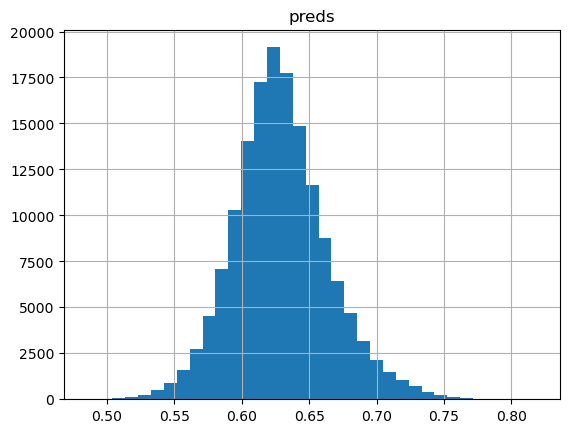

In [40]:
pro_preds_df['servewin'] = pro_df['servewin']

pro_preds_df[pro_preds_df['preds'] > 0][['preds']].hist(bins=35)

In [45]:
challenger_df['preds'] = challenger_preds_df['preds']
pro_df['preds'] = pro_preds_df['preds']

In [46]:
# creating dictionaries of predictions
pro_preds_df = pro_df[['servewin', 'preds']].copy()
challenger_preds_df = challenger_df[['servewin', 'preds']].copy()

pro_preds_dict = pro_df.set_index('servewin', append=True)['preds'].to_dict()
challenger_preds_dict = challenger_df.set_index('servewin', append=True)['preds'].to_dict()

In [48]:
predictions = []

for a, b in zip(rolling_df.match, rolling_df['ServeWin']):
    
    if (a, b) in pro_preds_dict:
        pred_ = pro_preds_dict[(a, b)]
    
    elif (a, b) in challenger_preds_dict:
        pred_ = challenger_preds_dict[(a, b)]
    
    else:
        pred_ = 0
    
    predictions.append(pred_)


Adding the predictions from the Ridge model to the rolling_df  
dataframe and building models  

Things to do:  
-Build surface-specific ridge models  
-Add rolling return deltas for 5 and 10 matches  
-Add the ServeWin predictions as features to the win probability model  
-Add total points won to each row of the main dataframe - fix the function  
-Incorporate sets won via SetsElo or otherwise

In [49]:
rolling_df['ridge_servewin_pred'] = predictions
rolling_df['hand'] = rolling_df['hand'].map({'R' : 0, 'L' : 1, 'U': 2})

In [50]:
# quick check to see if the numbers are right
condition1 = (rolling_df['ridge_servewin_pred'] > 0) & (rolling_df['tourney_level'] != 'C')
rolling_df[condition1][['ridge_servewin_pred', 'ServeWin']].corr()

,ridge_servewin_pred,ServeWin
ridge_servewin_pred,1.000000,0.422452
ServeWin,0.422452,1.000000


In [51]:
rolling_df.to_csv("rolling_dataframe.csv", index=False)

# Loading the Data with the Ridge Predictions

In [2]:
rolling_df = pd.read_csv('rolling_dataframe.csv', parse_dates=['tourney_date'])
rolling_df.head()

,match,player_id,ServeWin,ReturnWin,aces,double_faults,BpSaved,BpFaced,tourney_date,height,age,SvPts,1stIn,1stWon,2ndWon,tourney_level,surface,generic_winprob,surface_winprob,sets,points,rank,retired,best_of,hand,tourney_name,won,season,matches_played,matches_played_level,match_perc_at_level,days_since_last_match,ridge_servewin_pred
0,0,102358.0,0.696970,0.355932,6.0,0.0,2.0,2.0,2000-01-03,190.0,25.7,66.0,29.0,23.0,23.0,A,Hard,0.5,0.5,12,67.0,4.0,0,3.0,0.0,Adelaide,1,2000,0,0,1.0,0.0,0.0
1,0,103096.0,0.644068,0.303030,1.0,3.0,2.0,4.0,2000-01-03,173.0,22.0,59.0,37.0,25.0,13.0,A,Hard,0.5,0.5,7,58.0,56.0,0,3.0,0.0,Adelaide,0,2000,0,0,1.0,0.0,0.0
2,1,102533.0,0.595238,0.217391,3.0,5.0,0.0,3.0,2000-01-03,190.0,24.8,42.0,15.0,13.0,12.0,A,Hard,0.5,0.5,5,35.0,91.0,0,3.0,0.0,Adelaide,0,2000,0,0,1.0,0.0,0.0
3,1,103819.0,0.782609,0.404762,6.0,3.0,0.0,0.0,2000-01-03,185.0,18.3,46.0,28.0,24.0,12.0,A,Hard,0.5,0.5,12,53.0,64.0,0,3.0,0.0,Adelaide,1,2000,0,0,1.0,0.0,0.0
4,2,102998.0,0.777778,0.310680,8.0,3.0,0.0,1.0,2000-01-03,190.0,22.5,81.0,40.0,35.0,28.0,A,Hard,0.5,0.5,16,95.0,58.0,0,3.0,0.0,Adelaide,1,2000,0,0,1.0,0.0,0.0


In [3]:
rolling_df['serve_delta'] = rolling_df['ServeWin'].sub(rolling_df['ridge_servewin_pred'])
rolling_df['rolling_serve_delta_5'] = rolling_df.groupby('player_id')['serve_delta'].transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
rolling_df['rolling_serve_delta_10'] = rolling_df.groupby('player_id')['serve_delta'].transform(lambda x: x.shift().rolling(10, min_periods=1).max())

In [4]:
rolling_df['servewin_std'] = (
    rolling_df.groupby('player_id')['serve_delta']
    .transform(lambda x: x.shift().rolling(50, min_periods=1).std())
    .fillna(0.08)
)

rolling_df['serve_delta_zscore'] = (
    rolling_df
    .groupby('player_id')['serve_delta']
    .transform(lambda x: (x - x.mean()) / x.std())
    .fillna(0)
)
    
rolling_df['worst_serve_zscore_10'] = (
    rolling_df
    .groupby('player_id')['serve_delta_zscore']
    .transform(lambda x: x.shift().rolling(10, min_periods=1).min())
    .fillna(0)
)

rolling_df['best_serve_zscore_10'] = (
    rolling_df
    .groupby('player_id')['serve_delta_zscore']
    .transform(lambda x: x.shift().rolling(10, min_periods=1).max())
    .fillna(0)
)

rolling_df['expanding_retired'] = (
    rolling_df
    .groupby('player_id')['retired']
    .transform(lambda x: x.shift().mean())
)

In [5]:
# creating lagged player features
for n in range(1, 6):
    rolling_df[f'servewin_{n}back'] = rolling_df.groupby('player_id')['ServeWin'].transform(lambda x: x.shift(n))
    rolling_df[f'1stIn_{n}back'] = rolling_df.groupby('player_id')['1stIn'].transform(lambda x: x.shift(n))
    rolling_df[f'aces_{n}back'] = rolling_df.groupby('player_id')['aces'].transform(lambda x: x.shift(n))
    rolling_df[f'dfs_{n}back'] = rolling_df.groupby('player_id')['double_faults'].transform(lambda x: x.shift(n))

In [6]:
# creating a feature for a player's monthly play

rolling_df['month'] = rolling_df['tourney_date'].dt.month

rolling_df['month_perf'] = (
    rolling_df
    .groupby(['player_id', 'month'])['ServeWin']
    .transform(lambda x: x.shift().expanding().mean())
)

In [7]:
# getting rolling aces and double fault percentages
for n in range(5, 15, 5):
    rolling_df[f'rollingSum_aces_{n}'] = rolling_df.groupby('player_id')['aces'].transform(lambda x: x.shift().rolling(n, min_periods=1).sum())
    rolling_df[f'rollingSum_SvPts_{n}'] = rolling_df.groupby('player_id')['SvPts'].transform(lambda x: x.shift().rolling(n, min_periods=1).sum())
    rolling_df[f'rolling_ace_perc_{n}'] = rolling_df[f'rollingSum_aces_{n}'].div(rolling_df[f'rollingSum_SvPts_{n}'])
    rolling_df[f'rollingSum_df_{n}'] = rolling_df.groupby('player_id')['double_faults'].transform(lambda x: x.shift().rolling(n, min_periods=1).sum())
    rolling_df[f'rolling_df_perc_{n}'] = rolling_df[f'rollingSum_df_{n}'].div(rolling_df[f'rollingSum_SvPts_{n}'])


rolling_df['rollingSum_BPFaced_35'] = rolling_df.groupby('player_id')['BpFaced'].transform(lambda x: x.shift().rolling(35, min_periods=1).sum())
rolling_df['rollingSum_BPSaved_35'] = rolling_df.groupby('player_id')['BpSaved'].transform(lambda x: x.shift().rolling(35, min_periods=1).sum())
rolling_df['rolling_BPSave_perc'] = rolling_df['rollingSum_BPSaved_35'].div(rolling_df['rollingSum_BPFaced_35'])

# adding a few more match specific statistics
rolling_df['ace_perc'] = rolling_df['aces'].div(rolling_df['SvPts'])
rolling_df['df_perc'] = rolling_df['double_faults'].div(rolling_df['SvPts'])
rolling_df['1stIn_perc'] = rolling_df['1stIn'].div(rolling_df['SvPts'])
rolling_df['SvPtsWon'] = rolling_df['1stWon'].add(rolling_df['2ndWon'])
rolling_df['1stSvWin_2ndSvWin_ratio'] = rolling_df['1stWon'].div(rolling_df['2ndWon'])

# calculating season statistics
rolling_df['season'] = rolling_df['tourney_date'].dt.year
rolling_df['matches_played_season'] = rolling_df.groupby(['player_id', 'season']).cumcount()

In [8]:
# getting exponentially weighted moving averages
rolling_df['ewm_ace_perc'] = (
    rolling_df
    .groupby('player_id')['ace_perc'].transform(lambda x: x.shift().ewm(alpha=0.09).mean())
)

rolling_df['ewm_df_perc'] = (
    rolling_df
    .groupby('player_id')['df_perc'].transform(lambda x: x.shift().ewm(alpha=0.11).mean())
)

rolling_df['ewm_1stIn'] = (
    rolling_df
    .groupby('player_id')['1stIn_perc']
    .transform(lambda x: x.shift().ewm(alpha=0.13).mean())
)

In [129]:
# applying shrinkage to a few statistics

shrinkage_constant = 1

rolling_df['global_ace_perc'] = rolling_df['ace_perc'].shift().expanding().mean().fillna(0.067)
rolling_df['global_df_perc'] = rolling_df['df_perc'].shift().expanding().mean().fillna(0.04)
rolling_df['global_ewm_1stIn'] = rolling_df['1stIn_perc'].shift().expanding().mean().fillna(0.61)

rolling_df['shrinkage_factor'] = rolling_df['matches_played'] / (rolling_df['matches_played'] + shrinkage_constant)
rolling_df['adj_ewm_ace_perc'] = rolling_df['shrinkage_factor'] * rolling_df['ewm_ace_perc'] + \
                                ((1 - rolling_df['shrinkage_factor']) * rolling_df['global_ace_perc'])

rolling_df['adj_ewm_df_perc'] = rolling_df['shrinkage_factor'] * rolling_df['ewm_df_perc'] + \
                                ((1 - rolling_df['shrinkage_factor']) * rolling_df['global_df_perc'])
rolling_df['adj_ewm_1stIn'] = rolling_df['shrinkage_factor'] * rolling_df['ewm_1stIn'] + \
                                ((1 - rolling_df['shrinkage_factor']) * rolling_df['global_ewm_1stIn'])

In [46]:
rolling_df['serve_residual'] = rolling_df['ServeWin'] - rolling_df['ridge_servewin_pred']
rolling_df['ewm_serve_resid'] = (
    rolling_df
    .groupby('player_id')['serve_residual']
    .transform(lambda x: x.shift().ewm(alpha=0.3275).mean())
)

In [135]:
# creating a new dataframe to predict player match statistics
rolling_df.set_index('match', inplace=True)

# separating each match into two players using first/last
rolling_df_first = rolling_df.groupby(rolling_df.index).first()
rolling_df_last = rolling_df.groupby(rolling_df.index).last()

# concatenating the first and last with player/opponent prefixes
first_df = pd.concat([rolling_df_first.add_prefix('player_'),
                      rolling_df_last.add_prefix('opponent_')],
                      axis=1)

# concatenating the last and first with player/opponent prefixes
last_df = pd.concat([rolling_df_last.add_prefix('player_'),
                      rolling_df_first.add_prefix('opponent_')],
                      axis=1)

# concatenating the two so that we have them all in a frame
player_df = pd.concat([first_df, last_df]).sort_index()

In [136]:
player_df['player_tourney_name'] = player_df['player_tourney_name'].astype('category')

In [144]:
player_features = ['player_ridge_servewin_pred', 'opponent_ridge_servewin_pred', 
                   'player_rolling_serve_delta_5','opponent_rolling_serve_delta_5',
                   'player_rolling_serve_delta_10', 'opponent_rolling_serve_delta_10',
                   'player_match_perc_at_level', 'opponent_match_perc_at_level', 
                   'player_age', 'opponent_age', 
                   'player_matches_played_season', 'opponent_matches_played_season',
                   'player_rolling_ace_perc_10', 'opponent_rolling_ace_perc_10',
                   'player_rolling_df_perc_10', 'opponent_rolling_df_perc_10',
                   'player_rank', 'opponent_rank', 
                   'player_days_since_last_match', 'opponent_days_since_last_match',
                   'player_tourney_level', 'player_tourney_date', 
                   'player_generic_winprob', 'player_surface_winprob', 
                   'player_matches_played', 'opponent_matches_played',
                   'player_rolling_BPSave_perc', 'opponent_rolling_BPSave_perc',
                   'player_best_of', 'player_adj_ewm_ace_perc',
                   'player_tourney_name',
                   'player_adj_ewm_df_perc', 
                   'player_adj_ewm_1stIn',
                   'player_month_perf',
                   'player_ewm_serve_resid',
                   'player_servewin_1back',
                   'player_servewin_2back',
                   'player_servewin_3back',
                   'player_aces_1back',
                   'player_aces_2back',
                   'player_dfs_1back',
                   'player_hand', 'opponent_hand',
                   'player_ServeWin', 'opponent_ServeWin',
                   'player_ReturnWin', 'opponent_ReturnWin', 
                   'player_player_id','opponent_player_id',
                   'player_sets', 'opponent_sets',
                   'player_best_serve_zscore_10', 'opponent_best_serve_zscore_10',
                   'player_worst_serve_zscore_10', 'opponent_worst_serve_zscore_10',
                   'player_expanding_retired', 'opponent_expanding_retired',
                   'player_servewin_std', 'opponent_servewin_std',
                   'player_points', 'opponent_points',
                   'player_won']

In [145]:
# creating the player model dataframe and filtering out rows with missing 
# predictions
player_model_df = player_df[player_features].copy()

print("the original shape of the df is:", player_model_df.shape)

player_model_df['player_tourney_level'] = player_model_df['player_tourney_level'].astype('category')

player_model_df = player_model_df[player_model_df['player_ridge_servewin_pred'] > 0].copy()
player_model_df = player_model_df[player_model_df['opponent_ridge_servewin_pred'] > 0].copy()

print("after filtering out rows without a ridge prediction the shape is:", player_model_df.shape)

the original shape of the df is: (316192, 62)
after filtering out rows without a ridge prediction the shape is: (301320, 62)


In [146]:
# calculating and printing baselines
baseline_servewin = mean_absolute_error(player_model_df['player_ServeWin'], player_model_df['player_ridge_servewin_pred'])
baseline_rsquared = r2_score(player_model_df['player_ServeWin'], player_model_df['player_ridge_servewin_pred'])

print("baseline mae to beat for servewin:", baseline_servewin)
print("baseline rsquared score for ridge prediction:", baseline_rsquared)

baseline mae to beat for servewin: 0.06890683840214465
baseline rsquared score for ridge prediction: 0.14978485726768698


In [147]:
player_model_df = player_model_df[player_model_df['player_tourney_level'] != 'C'].copy()

baseline_servewin = mean_absolute_error(player_model_df['player_ServeWin'], player_model_df['player_ridge_servewin_pred'])
baseline_rsquared = r2_score(player_model_df['player_ServeWin'], player_model_df['player_ridge_servewin_pred'])

print("baseline mae to beat for servewin:", baseline_servewin)
print("baseline rsquared score for ridge prediction:", baseline_rsquared)
print(player_model_df.shape)

baseline mae to beat for servewin: 0.06588419450141807
baseline rsquared score for ridge prediction: 0.17629512445761475
(151990, 62)


In [148]:
# creating a model to predict player_one's servewin%
from lightgbm import LGBMClassifier

cv = TimeSeriesSplit(n_splits=12)

X = player_model_df.drop(columns=['player_won', 'player_ServeWin', 'player_ReturnWin', 
                                  'opponent_ServeWin', 'opponent_ReturnWin', 'player_tourney_date', 
                                  'player_player_id', 'opponent_player_id', 'player_generic_winprob',
                                  'player_surface_winprob',  'player_sets', 'opponent_sets',
                                  'player_points', 'opponent_points', 'opponent_best_serve_zscore_10'
                                  ])

y = player_model_df['player_ServeWin']

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

oof = np.zeros(len(X))

for train, val in cv.split(X, y):
    
    train_x = X.iloc[train]
    train_y = y[train]
    
    val_x = X.iloc[val]
    val_y = y[val]
    
    params = {'n_estimators': 800,
              'max_depth': 3,
              'learning_rate': 0.07010945890585066,
              'subsample': 0.5603585503141538,
              'colsample_bytree': 0.5875185853973193,
              'eval_metric' : 'l2'}
    
    target_cols = ['player_tourney_name', 'player_tourney_level']
#     encoder = TargetEncoder(cols=target_cols, min_samples_leaf=15, smoothing=3)
#     encoder = GLMMEncoder()
    encoder = CatBoostEncoder()

    train_x[target_cols] = encoder.fit_transform(train_x[target_cols], train_y)
    val_x[target_cols] = encoder.transform(val_x[target_cols])
    
    serve_model = LGBMRegressor(**params)
    serve_model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=15, verbose=0)
    
    preds = serve_model.predict(val_x)
    oof[val] = preds

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric


In [150]:
serve_oof_df = pd.DataFrame({'pred' : oof, 'actual' : y})
serve_oof_df['player_baseline'] = X['player_ridge_servewin_pred'].values
serve_oof_df = serve_oof_df[serve_oof_df['pred'] > 0.0].copy()
serve_oof_df['residuals'] = serve_oof_df['actual'].sub(serve_oof_df['pred'])

baseline_r2 = r2_score(serve_oof_df['actual'], serve_oof_df['player_baseline'])
model_r2 = r2_score(serve_oof_df['actual'], serve_oof_df['pred'])
model_mae = mean_absolute_error(serve_oof_df['actual'], serve_oof_df['pred'])

print("filtered baseline r2_score:", baseline_r2)
print("filtered model r2_score:", model_r2)
print("delta r2 between baseline and model:", baseline_r2 - model_r2)
print("model mean absolute error:", model_mae)

filtered baseline r2_score: 0.17778660412332392
filtered model r2_score: 0.2618452779389634
delta r2 between baseline and model: -0.08405867381563947
model mean absolute error: 0.06241191624180657


In [151]:
serve_model_fi = (
    pd.DataFrame({'feature' : train_x.columns,
                  'importance' : serve_model.feature_importances_})
)

serve_model_fi.sort_values(by='importance', ascending=False)

,feature,importance
0,player_ridge_servewin_pred,226
27,player_tourney_name,186
22,opponent_matches_played,164
17,opponent_rank,164
9,opponent_age,154
21,player_matches_played,154
16,player_rank,136
8,player_age,129
13,opponent_rolling_ace_perc_10,108
6,player_match_perc_at_level,106


In [152]:
# now we're going to take the out of fold predictions 
# and add them to the player_model_df

player_model_df['player_lgbm_servewin_pred'] = oof

# Training Point Differential Model

Now we reshape the data to again have one row for each match.  
The player's stats and the opponent's stats will be concatenated  
horizontally with prefixes added to the opponent features.

In [153]:
player_cols = ['player_player_id', 'player_ridge_servewin_pred', 'player_rolling_serve_delta_5', 
               'player_rolling_serve_delta_10', 'player_match_perc_at_level',
               'player_age', 'player_matches_played_season', 'player_rolling_ace_perc_10',
               'player_rolling_df_perc_10', 'player_rank', 'player_days_since_last_match',
               'player_tourney_level', 'player_tourney_date', 'player_generic_winprob',
               'player_surface_winprob', 'player_matches_played', 'player_ServeWin',
               'player_ReturnWin', 'player_lgbm_servewin_pred', 'player_sets', 'player_points', 
               'player_won', 'player_best_of', 'player_rolling_BPSave_perc', 'player_servewin_std',
               'player_worst_serve_zscore_10', 'player_best_serve_zscore_10', 'player_expanding_retired',
               'player_hand']

In [154]:
# creating a dataframe for the matches from the player_df above

player_model_df = player_model_df[player_cols].copy()

# using random numbers to create player1 and player2 dfs in order to have
# target features that are a mixture of 1s and 0s
player_model_df['random_assignment'] = np.random.uniform(0, 234423, len(player_model_df))
player_model_df['random_mean'] = player_model_df.groupby(player_model_df.index)['random_assignment'].mean()

player_one = player_model_df[player_model_df['random_assignment'] > player_model_df['random_mean']].copy()
player_one.drop(columns=['random_assignment', 'random_mean'], inplace=True)

player_two = player_model_df[player_model_df['random_assignment'] < player_model_df['random_mean']].copy()
player_two.columns = [x.replace('player', 'player_2') for x in player_two.columns]
player_two.drop(columns=['random_assignment', 'random_mean', 'player_2_won'], inplace=True)

print("the length of each df is the same:", len(player_one) == len(player_two))

the length of each df is the same: True


In [155]:
# combining the two player dataframes into one
match_df = player_one.join(player_two)
match_df.rename(columns={'player_player_id' : 'player_id',
                 'player_2_player_2_id' : 'player_2_id'},
                inplace=True)

print("the original shape of our match_df is:", match_df.shape)

baseline_logloss_match = log_loss(match_df['player_won'], match_df['player_generic_winprob'])
baseline_brier_match = brier_score_loss(match_df['player_won'], match_df['player_generic_winprob'])

print("baseline logloss for player 1 to beat:", baseline_logloss_match)
print("baseline brier score loss to beat:", baseline_brier_match)

the original shape of our match_df is: (75995, 57)
baseline logloss for player 1 to beat: 0.6011294044406864
baseline brier score loss to beat: 0.20753797988665632


In [156]:
# defining the feature to train the point differential model 
match_df['point_differential'] = match_df['player_points'].sub(match_df['player_2_points'])

In [157]:
from lightgbm import LGBMClassifier

cv = TimeSeriesSplit(n_splits=12)

X = match_df.drop(columns=['player_won', 'player_ServeWin',
                           'player_ReturnWin', 'player_2_ServeWin', 
                           'player_2_ReturnWin', 'player_2_generic_winprob',
                           'player_2_surface_winprob', 'player_points',
                           'player_tourney_date', 'player_2_tourney_date', 
                           'player_2_tourney_level', 'player_2_best_of',
                           'player_2_id', 'player_id', 'player_won', 'point_differential',
                           'player_2_rolling_serve_delta_10', 'player_rolling_ace_perc_10',
                           'player_rolling_df_perc_10', 'player_rolling_serve_delta_10',
                           'player_sets', 'player_points', 'player_2_sets', 'player_2_points'])

y = match_df['point_differential']

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

oof = np.zeros(len(X))

for train, val in cv.split(X, y):
    
    train_x = X.iloc[train]
    train_y = y[train]
    
    val_x = X.iloc[val]
    val_y = y[val]
    
    params = {'learning_rate': 0.022809248839274748,
              'max_depth': 4,
              'num_leaves': 25,
              'n_estimators': 705,
              'min_child_weight': 12,
              'colsample_bytree': 0.607177133492038,
              'subsample': 0.6364066205409564,
              'objective' : 'quantile',
              'alpha' : 0.5}
    

    model = LGBMRegressor(**params)
    model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=15, verbose=0)
    
    preds = model.predict(val_x)
    oof[val] = preds

In [158]:
oof_pts_df = pd.DataFrame({'pred' : oof, 'actual' : y})
oof_pts_df = oof_pts_df[oof_pts_df['pred'] != 0.000].copy()

In [159]:
match_df['pred_points_differential'] = oof
match_df = match_df[match_df['pred_points_differential'] != 0.0].copy()

print("match_df now has this many samples:", match_df.shape[0])

match_df now has this many samples: 70140


# Training Match Win Probability Model



In [261]:
from lightgbm import LGBMClassifier

cv = TimeSeriesSplit(n_splits=12)

X = match_df.drop(columns=['player_won', 'player_ServeWin',
                           'player_ReturnWin', 'player_2_ServeWin', 
                           'player_2_ReturnWin', 'player_2_generic_winprob',
                           'player_2_surface_winprob', 
                           'player_tourney_date', 'player_2_tourney_date', 
                           'player_2_tourney_level', 'player_2_best_of',
                           'player_2_id', 'player_id', 'point_differential',
                           'player_2_rolling_serve_delta_10', 'player_rolling_ace_perc_10',
                           'player_rolling_df_perc_10', 'player_rolling_serve_delta_10',
                           'player_sets', 'player_points', 'player_2_sets', 'player_2_points',
                           'player_hand', 'player_2_hand'])

y = match_df['player_won']

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

oof = np.zeros(len(X))

for train, val in cv.split(X, y):
    
    train_x = X.iloc[train]
    train_y = y[train]
    
    val_x = X.iloc[val]
    val_y = y[val]
    
    params = {'learning_rate': 0.022809248839274748,
              'max_depth': 4,
              'num_leaves': 25,
              'n_estimators': 705,
              'min_child_weight': 12,
              'colsample_bytree': 0.607177133492038,
              'subsample': 0.6364066205409564}
    
    model = LGBMClassifier(**params)
    model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=15, verbose=0)
    
    preds = model.predict_proba(val_x)[:,1]
    oof[val] = preds

In [262]:
# creating a feature importances dataframe

wp_model_fi = (
    pd.DataFrame({'feature' : train_x.columns,
                  'importance' : model.feature_importances_})
    .sort_values(by='importance', ascending=False)
)

wp_model_fi

,feature,importance
35,pred_player_one_win,541
34,pred_points_differential,352
9,player_surface_winprob,232
3,player_age,205
28,player_2_lgbm_servewin_pred,190
8,player_generic_winprob,183
21,player_2_age,174
11,player_lgbm_servewin_pred,167
6,player_days_since_last_match,160
20,player_2_match_perc_at_level,134


In [263]:
oof_clf_df = pd.DataFrame({'pred' : oof, 'actual' : y})
oof_clf_df['player_one_win_prob'] = X['player_generic_winprob']
oof_clf_df['player_one_surface_prob'] = X['player_surface_winprob']
oof_clf_df = oof_clf_df[oof_clf_df['pred'] > 0.0].copy()

In [264]:
print("baseline log loss with generic elo:", log_loss(oof_clf_df['actual'], oof_clf_df['player_one_win_prob']))
print("model log_loss on out of fold preds:", log_loss(oof_clf_df['actual'], oof_clf_df['pred']))
print("model brier loss on out of fold preds:", brier_score_loss(oof_clf_df['actual'], oof_clf_df['pred']))
print("the delta for logloss is:", log_loss(oof_clf_df['actual'], oof_clf_df['player_one_win_prob']) - log_loss(oof_clf_df['actual'], oof_clf_df['pred']))

baseline log loss with generic elo: 0.5966028698103851
model log_loss on out of fold preds: 0.577754183411888
model brier loss on out of fold preds: 0.1979766105267886
the delta for logloss is: 0.018848686398497128


In [265]:
match_df['pred_player_one_win'] = oof
match_df = match_df[match_df['pred_player_one_win'] > 0.0].copy()
match_df['month'] = match_df['player_2_tourney_date'].dt.month
match_df['season'] = match_df['player_2_tourney_date'].dt.year

generic_elo_by_level = (
    match_df
    .groupby('player_tourney_level', observed=True)
    .apply(lambda x: brier_score_loss(x['player_won'], x['player_generic_winprob']))
)


brier_by_level = (
    match_df
    .groupby('player_tourney_level', observed=True)
    .apply(lambda x: brier_score_loss(x['player_won'], x['pred_player_one_win']))
)

level_comparison = pd.concat([generic_elo_by_level, brier_by_level], axis=1)
level_comparison.columns = ['elo_brier_score', 'model_brier_score']

level_comparison

,elo_brier_score,model_brier_score
player_tourney_level,,
G,0.194978,0.184572
A,0.208364,0.201670
M,0.212059,0.204959
F,0.191032,0.190349
D,0.174644,0.166604


In [266]:
# looking at how we do predicting the performance of some of the best players

PLAYER = 104925.0

player_df = (
    match_df[match_df['player_id'] == PLAYER]
    [['player_tourney_date', 'pred_player_one_win', 'player_generic_winprob', 'player_won']]
    .copy()
)

filtered_player_df = player_df[player_df['player_tourney_date'] >=  '2007-01-01']

brier_score_loss(filtered_player_df['player_won'], filtered_player_df['pred_player_one_win'])

0.10334164837287997

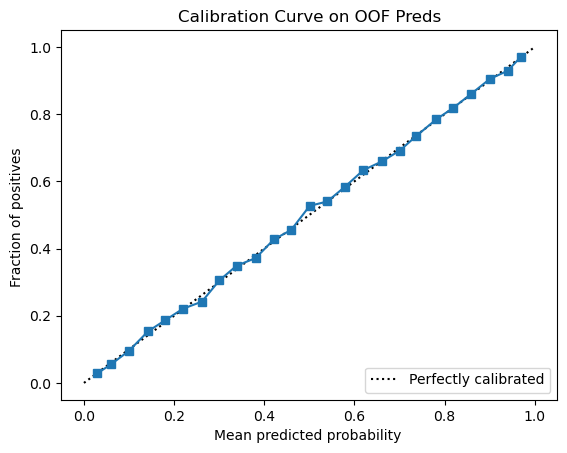

In [318]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

y_prob = match_df['pred_player_one_win'].values
prob_true, prob_pred = calibration_curve(match_df['player_won'], match_df['pred_player_one_win'], n_bins=25)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()
plt.title("Calibration Curve on OOF Preds")
plt.show()

In [259]:
def plot_player(player_id=103819.0):
    fig, ax = plt.subplots(figsize=(16, 6))
    
    name = player_name_dict[player_id]
    columns = ['player_tourney_date', 'pred_player_one_win']
    
    player_df = (
        match_df[match_df['player_id'] == player_id][columns]
    )

    # date as index
    player_df.set_index('player_tourney_date', inplace=True)

    # scatterplot and grid
    plt.scatter(player_df.index, player_df['pred_player_one_win'], label='Model Predictions', marker='o', s=6)

    plt.grid(True)
    
    # title and axis labels
    plt.title(f"{name}'s Predictions")
    plt.xlabel("Tourney Date")
    plt.ylabel("Model Win Prediction")

    # adding the dashed line at 0.5
    ax.axhline(y=0.5, color='r', linestyle='--')
    
    plt.legend()

    # rotating the xticks
    plt.xticks(rotation=45)

    plt.show()

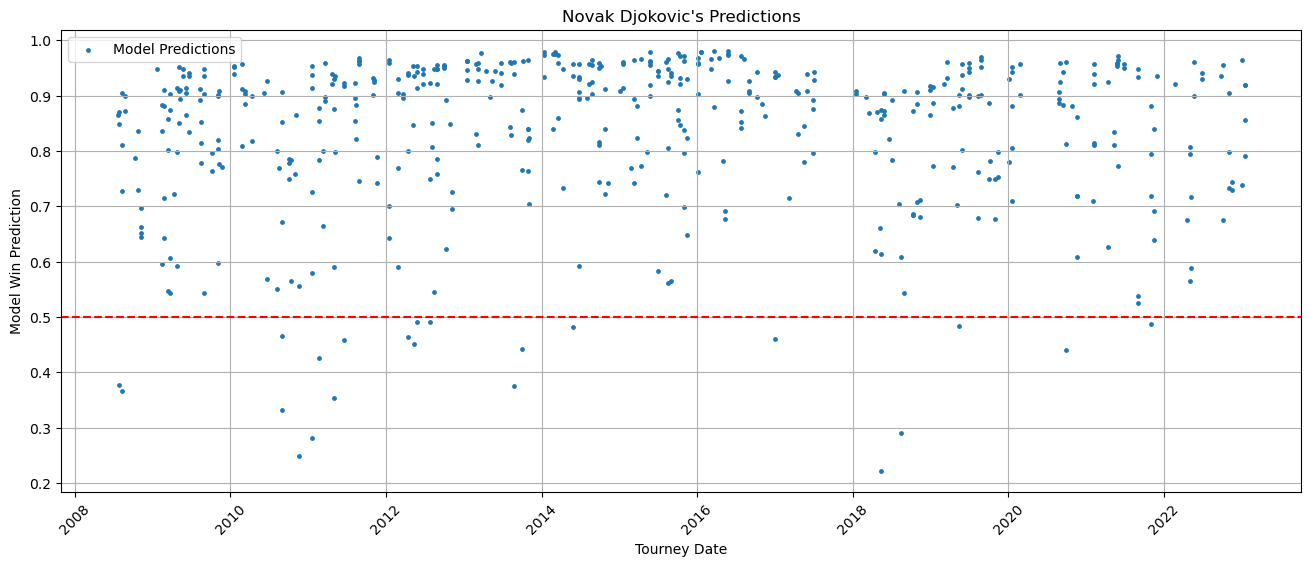

In [260]:
plot_player(104925.0)

In [371]:
# creating and saving a csv for market analysis
match_cols_for_bet = ['player_tourney_date', 'player_id', 'player_2_id', 'pred_player_one_win']

match_df[match_cols_for_bet].to_csv("prediction_df.csv")

In [784]:
# calculating brier score loss 
model_brier = lambda x: brier_score_loss(x['player_one_winner'], x['model_w_pred'])
pinnacle_vegas_brier = lambda x: brier_score_loss(x['player_one_winner'], x['pinnacle_vegas_pred_w'])

briers_df = (
    pd.concat([trial.groupby(['season', 'tourney_name']).apply(model_brier),
               trial.groupby(['season', 'tourney_name']).apply(pinnacle_vegas_brier)], axis=1)
    .rename(columns={0 : 'model', 1 : 'pinnacle'})
)

briers_df['model_wins'] = (briers_df['model'] < briers_df['pinnacle']).astype(int)

# Optuna Hyperparameter Search

In [303]:
from lightgbm import LGBMClassifier

def objective(trial):
    cv = TimeSeriesSplit(n_splits=12)

    X = match_df.drop(columns=['player_won', 'player_ServeWin',
                               'player_ReturnWin', 'player_2_ServeWin', 
                               'player_2_ReturnWin', 'player_2_generic_winprob',
                               'player_2_surface_winprob',
                               'player_tourney_date', 'player_2_tourney_date', 
                               'player_2_tourney_level', 'player_2_best_of',
                               'player_2_id', 'player_id', 'point_differential',
                               'player_2_rolling_serve_delta_10', 'player_rolling_ace_perc_10',
                               'player_rolling_df_perc_10', 'player_rolling_serve_delta_10',
                               'player_sets', 'player_points', 'player_2_sets', 'player_2_points'])

    y = match_df['player_won']

    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    oof = np.zeros(len(X))

    for train, val in cv.split(X, y):

        train_x = X.iloc[train]
        train_y = y[train]

        val_x = X.iloc[val]
        val_y = y[val]
        
        boosting_types = ['gbdt', 'dart']
        params = {
            'boosting' : trial.suggest_categorical('boosting', boosting_types),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
            'max_depth' : trial.suggest_int('max_depth', 2, 12),
            'num_leaves' : trial.suggest_int('num_leaves', 10, 130, step=2),
            'n_estimators' : trial.suggest_int('n_estimators', 150, 1000, step=5),
            'min_child_weight' : trial.suggest_int('min_child_weight', 2, 30),
            'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 0.8),
            'subsample' : trial.suggest_float('subsample', 0.5, 0.99)
            }

        model = LGBMClassifier(**params)
        model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=15)

        preds = model.predict_proba(val_x)[:,1]
        oof[val] = preds
    
    oof_clf_df = pd.DataFrame({'pred' : oof, 'actual' : y})
    oof_clf_df['player_one_win_prob'] = X['player_generic_winprob']
    oof_clf_df['player_one_surface_prob'] = X['player_surface_winprob']
    oof_clf_df = oof_clf_df[oof_clf_df['pred'] > 0.0].copy()
    
    return log_loss(oof_clf_df['actual'], oof_clf_df['pred'])